In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import layers
from keras import optimizers
from keras.models import Model
from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
from keras.models import load_model
import re
import string
import json

Using TensorFlow backend.
d:\Program Files\Anaconda\envs\nerExt\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\Program Files\Anaconda\envs\nerExt\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\Program Files\Anaconda\envs\nerExt\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\Program Files\Anaconda\envs\nerExt\lib

In [2]:
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5

In [3]:
# Pre-process data

data_df = pd.read_csv("dataset/ner_dataset.csv", encoding="iso-8859-1", header=0)

data_df = data_df.fillna(method="ffill")
data_df["Sentence #"] = data_df["Sentence #"].apply(lambda s: s[9:])
data_df["Sentence #"] = data_df["Sentence #"].astype("int32")

word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
MAX_SENTENCE = word_counts.max()[0]

all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tag"].values))

word2index = {word: idx + 2 for idx, word in enumerate(all_words)}
word2index["<UNK>"]=0
word2index["<PAD>"]=1
index2word = {idx: word for word, idx in word2index.items()}

tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["<PADTAG>"] = 0
index2tag = {idx: word for word, idx in tag2index.items()}

def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()

X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]

X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]

X = [sentence + [word2index["<PAD>"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["<PADTAG>"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]

TAG_COUNT = len(tag2index)
y = [np.eye(TAG_COUNT)[sentence] for sentence in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

WORD_COUNT = len(index2word)

# Save word2index and index2tag
with open("word2index.json", "w") as f:
    json.dump(word2index, f)
with open("index2tag.json", "w") as f:
    json.dump(index2tag, f)

In [4]:
# biLSTM-CRF Model

input_layer = layers.Input(shape=(MAX_SENTENCE,))

model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = optimizers.Adam(lr=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 104, 50)           1759000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 100)          40400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 100)          10100     
_________________________________________________________________
crf_1 (CRF)                  (None, 104, 18)           2178      
Total params: 1,811,678
Trainable params: 1


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 81s 2ms/step - loss: 0.5352 - crf_accuracy: 0.8790 - val_loss: 0.1599 - val_crf_accuracy: 0.9674
Epoch 2/5
38846/38846 [==============================] - 78s 2ms/step - loss: 0.1183 - crf_accuracy: 0.9698 - val_loss: 0.0793 - val_crf_accuracy: 0.9757
Epoch 3/5
38846/38846 [==============================] - 85s 2ms/step - loss: 0.0670 - crf_accuracy: 0.9799 - val_loss: 0.0563 - val_crf_accuracy: 0.9847
Epoch 4/5
38846/38846 [==============================] - 83s 2ms/step - loss: 0.0448 - crf_accuracy: 0.9880 - val_loss: 0.0389 - val_crf_accuracy: 0.9897
Epoch 5/5
38846/38846 [==============================] - 83s 2ms/step - loss: 0.0301 - crf_accuracy: 0.9918 - val_loss: 0.0301 - val_crf_accuracy: 0.9914


4796/4796 [==============================] - 4s 907us/step

Test accuracy: 0.9911424604130348


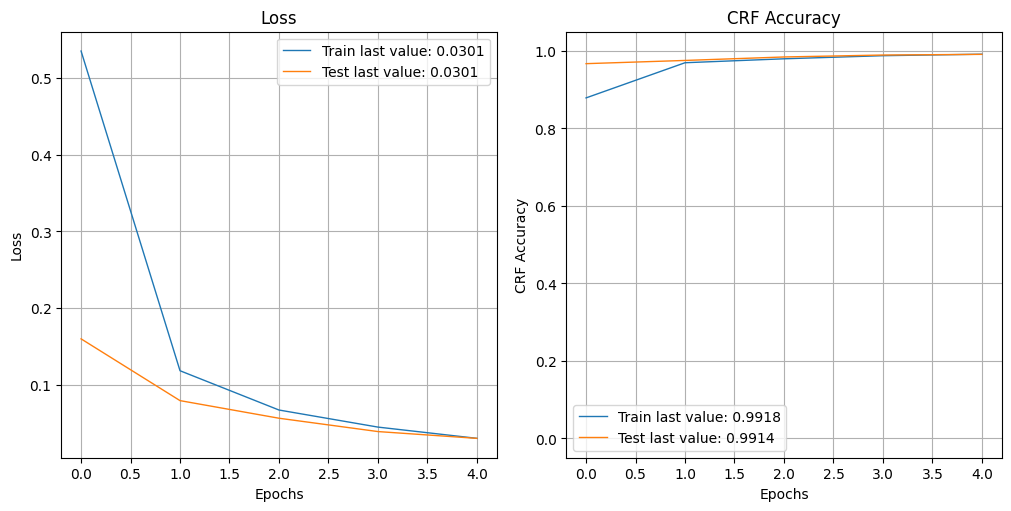

In [5]:
# Training Model

history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=1)

print("\n")
test_loss, test_acc = ner_model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', test_acc)

ner_model.save("pretrained_model.h5")

plot_history(history.history)
plt.show()

In [8]:
# Predicting

sentence = "President Obama became the first sitting American president to visit Hiroshima"
# sentence = "Chinese President Xi Jinping walks into the St. George's Hall at the Kremlin in Moscow, Russia, March 21, 2023. Xi on Tuesday held talks with Putin in Moscow. Putin held a solemn welcome ceremony for Xi Jinping at the St. George's Hall."
# sentence = "Today is Tuesday."

re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
sentence = re_tok.sub(r"  ", sentence).split()

padded_sentence = sentence + ["<PAD>"] * (MAX_SENTENCE - len(sentence))
padded_sentence = [word2index.get(w, 0) for w in padded_sentence]

model = load_model('pretrained_model.h5', custom_objects={'CRF': CRF,'crf_loss': losses.crf_loss, 'crf_accuracy': metrics.crf_accuracy})

pred = model.predict(np.array([padded_sentence]))
pred = np.argmax(pred, axis=-1)[0]
# pred_str = [str(i) for i in pred[0]]

retval = ""
for w, p in zip(sentence, pred):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"
print(retval)

President      : B-per
Obama          : I-per
became         : O    
the            : O    
first          : O    
sitting        : O    
American       : B-gpe
president      : O    
to             : O    
visit          : O    
Hiroshima      : B-geo

